**Задание:** Предсказание просрочки / просрочки 30 дней / просрочки 60 дней на основании данных финансовой отчетности компаний-контрагентов и других показателей

**Целевая переменная:** 
Самый важный(целевой) признак – Макс.ПДЗ (19-20 год), представляющий собой данные о максимальном сроке дебиторской задолженности на момент окончания этого года, выраженный в днях.  Анализ этого признака и возможность его предсказания являются краеугольными в данной задаче.
Также о ПДЗ есть следующая информация:

Сред. ПДЗ за год, дней, Кол-во просрочек свыше 5-ти дней за  год, шт., Общая сумма ПДЗ свыше 5-ти дней за  год, руб., Кол-во раз ПДЗ за  год, шт.

За 2021 год данные иные:
ПДЗ 1-30 – отражает, была ли просрочка в течении года в диапазоне от 1 до 30 дней
ПДЗ 31-90 - отражает, была ли просрочка в течении года в диапазоне от 31 до 90 дней
ПДЗ 91-365 - отражает, была ли просрочка в течении года в диапазоне от 91 до 365 дней
ПДЗ более 365 -  отражает, была ли просрочка более 365 дней


**Метрика качества:
Best Threshold	F-Score	Precision	Recall	roc_auc_score** 

**Описание датасета:**

Представлены 3 файла 
 - agents2019, agents2020, agents2021

В них представлены фин показатели за последние 3 года, а также:

Сред. ПДЗ, Кол-во просрочек свыше 5-ти дней, Общая сумма ПДЗ свыше 5-ти дней, Кол-во раз ПДЗ за 2019 год, шт.
В 2020 и 2021 годах - некие фактические показатели (1-60 штук), которые сводятся к итоговой величине
 

In [1]:
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score as r2, mean_squared_error as mse, roc_auc_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline

import statsmodels.api as sm
import statsmodels.formula.api as smf

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from scipy.stats import norm
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

import matplotlib.image as img
from scipy import stats
from IPython.display import Image

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

pd.set_option('display.float_format', '{:.2f}'.format)


## Содержание
* [1. Общее описание датасета](#prep)
* [2. Предобработка данных](#functions)
* [3. Целевая переменная](#target)
* [4. Признаки](#features)
* [5. Моделирование](#models)
* [6. Проверка на валидационном сете](#valid)
* [7. API / Pipeline](#pipeline)
* [8. DFD модель (Flask / Spark / Stream)](#flask)
* [9. Выводы и заключение](#rezult)


# 1. Общее описание датасета<a class='anchor' id='prep'>

In [2]:
#track to files
data_2019 = pd.read_csv('agents2019.csv', sep=',')
data_2020 = pd.read_csv('agents2020.csv', sep=',')
data_2021 = pd.read_csv('agents2021.csv', sep=',')

In [3]:
all_columns = ['Наименование ДП', 'Макс. ПДЗ за 2019 год, дней', 'Сред. ПДЗ за 2019 год, дней', 
                       'Кол-во просрочек свыше 5-ти дней за 2019 год, шт.', 'Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.', 
                      'Кол-во раз ПДЗ за 2019 год, шт.',
               'Макс. ПДЗ за 2020 год, дней', 'Сред. ПДЗ за 2020 год, дней', 'Кол-во просрочек свыше 5-ти дней за 2020 год, шт.',
               'Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.', 'Кол-во раз ПДЗ за 2020 год, шт.',
               '2016, Основные средства , RUB', '2017, Основные средства , RUB', '2018, Основные средства , RUB', 
               '2019, Основные средства , RUB', '2020, Основные средства , RUB',
               '2016, Оборотные активы, RUB', '2017, Оборотные активы, RUB', '2018, Оборотные активы, RUB', 
               '2019, Оборотные активы, RUB', '2020, Оборотные активы, RUB', 
               '2016, Капитал и резервы, RUB', '2017, Капитал и резервы, RUB', '2018, Капитал и резервы, RUB', 
               '2019, Капитал и резервы, RUB', '2020, Капитал и резервы, RUB', 
               '2016, Заёмные средства (долгосрочные), RUB', '2017, Заёмные средства (долгосрочные), RUB', 
               '2018, Заёмные средства (долгосрочные), RUB', '2019, Заёмные средства (долгосрочные), RUB', '2020, Заёмные средства (долгосрочные), RUB',
               '2016, Заёмные средства (краткосрочные), RUB', '2017, Заёмные средства (краткосрочные), RUB',
               '2018, Заёмные средства (краткосрочные), RUB', '2019, Заёмные средства (краткосрочные), RUB',
               '2020, Заёмные средства (краткосрочные), RUB',
               '2016, Краткосрочные обязательства, RUB', '2017, Краткосрочные обязательства, RUB', 
               '2018, Краткосрочные обязательства, RUB', '2019, Краткосрочные обязательства, RUB',
               '2020, Краткосрочные обязательства, RUB',
               '2016, Выручка, RUB', '2017, Выручка, RUB', '2018, Выручка, RUB', '2019, Выручка, RUB', '2020, Выручка, RUB',
               '2016, Прибыль (убыток) от продажи, RUB', '2017, Прибыль (убыток) от продажи, RUB',
               '2018, Прибыль (убыток) от продажи, RUB', '2019, Прибыль (убыток) от продажи, RUB', '2020, Прибыль (убыток) от продажи, RUB', 
               'Итого',
               'ПДЗ 1-30', 'ПДЗ 31-90', 'ПДЗ 91-365', 'ПДЗ более 365']

In [4]:
rename_columns = {'Наименование ДП':'name', 
                  'Макс. ПДЗ за 2019 год, дней':'max_pdz_19',
                            'Сред. ПДЗ за 2019 год, дней':'mean_pdz_19',
                            'Кол-во просрочек свыше 5-ти дней за 2019 год, шт.': 'count5_pdz_19',
                            'Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.': 'sum5_pdz_19',
                            'Кол-во раз ПДЗ за 2019 год, шт.': 'countall_pdz_19',
                  'Макс. ПДЗ за 2020 год, дней':'max_pdz_20',
                            'Сред. ПДЗ за 2020 год, дней':'mean_pdz_20',
                            'Кол-во просрочек свыше 5-ти дней за 2020 год, шт.': 'count5_pdz_20',
                            'Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.': 'sum5_pdz_20',
                            'Кол-во раз ПДЗ за 2020 год, шт.': 'countall_pdz_20',
                            '2016, Основные средства , RUB': 'oc_t-3',
                            '2017, Основные средства , RUB': 'oc_t-2', 
                            '2018, Основные средства , RUB': 'oc_t-1',
                  '2019, Основные средства , RUB': 'oc_t0',
                  '2020, Основные средства , RUB': 'oc_t1',
                            '2016, Оборотные активы, RUB': 'oborot_t-3', 
                            '2017, Оборотные активы, RUB': 'oborot_t-2',
                            '2018, Оборотные активы, RUB': 'oborot_t-1',
                  '2019, Оборотные активы, RUB': 'oborot_t0',
                  '2020, Оборотные активы, RUB': 'oborot_t1',
                            '2016, Капитал и резервы, RUB': 'kapital_t-3',
                            '2017, Капитал и резервы, RUB': 'kapital_t-2', 
                            '2018, Капитал и резервы, RUB': 'kapital_t-1',
                  '2019, Капитал и резервы, RUB': 'kapital_t0',
                  '2020, Капитал и резервы, RUB': 'kapital_t1',
                            '2016, Заёмные средства (долгосрочные), RUB': 'dolg_zaem_t-3',
                            '2017, Заёмные средства (долгосрочные), RUB': 'dolg_zaem_t-2',
                            '2018, Заёмные средства (долгосрочные), RUB': 'dolg_zaem_t-1',
                  '2019, Заёмные средства (долгосрочные), RUB': 'dolg_zaem_t0',
                  '2020, Заёмные средства (долгосрочные), RUB': 'dolg_zaem_t1',
                            '2016, Заёмные средства (краткосрочные), RUB': 'krat_zaem_t-3',
                            '2017, Заёмные средства (краткосрочные), RUB': 'krat_zaem_t-2',
                            '2018, Заёмные средства (краткосрочные), RUB': 'krat_zaem_t-1',
                  '2019, Заёмные средства (краткосрочные), RUB': 'krat_zaem_t0',
                  '2020, Заёмные средства (краткосрочные), RUB': 'krat_zaem_t1',
                            '2016, Краткосрочные обязательства, RUB': 'krat_liabil_t-3',
                            '2017, Краткосрочные обязательства, RUB': 'krat_liabil_t-2',
                            '2018, Краткосрочные обязательства, RUB': 'krat_liabil_t-1',
                  '2019, Краткосрочные обязательства, RUB': 'krat_liabil_t0',
                  '2020, Краткосрочные обязательства, RUB': 'krat_liabil_t1',
                            '2016, Выручка, RUB': 'revenue_t-3',
                            '2017, Выручка, RUB': 'revenue_t-2',
                            '2018, Выручка, RUB': 'revenue_t-1',
                  '2019, Выручка, RUB': 'revenue_t0',
                  '2020, Выручка, RUB': 'revenue_t1',
                            '2016, Прибыль (убыток) от продажи, RUB': 'profit_t-3',
                            '2017, Прибыль (убыток) от продажи, RUB': 'profit_t-2',
                            '2018, Прибыль (убыток) от продажи, RUB': 'profit_t-1',
                  '2019, Прибыль (убыток) от продажи, RUB': 'profit_t0',
                  '2020, Прибыль (убыток) от продажи, RUB': 'profit_t1',
                  'Итого': 'Itog',
                  'ПДЗ 1-30': 'PDZ30',
                  'ПДЗ 31-90': 'PDZ90', 
                  'ПДЗ 91-365': 'PDZ365', 
                  'ПДЗ более 365': 'PDZ700'
                           }

Целью работы является построение модели прогнозирования критической просрочки дебиторской задолженности компании в зависимости от различных параметров компании.

Инструментом моделирования служат различные модели машинного обучения:
дерево решений;
случайный лес;
gradient Boosting;
и другие...

Будут рассчитаны различные метрики качества моделей и выбрана наиболее оптимальная.

Тестирование модели и определение параметров будет проводится на данных за 2019-2020 годы, валидация - на данных 2021 года.  

Поскольку целевой показатель в 2021 году отличается от данных предыдущих лет (не прямо сопоставимые данные), в качестве целевого показателя (таргета) будет составлен сводный показатель, итоговые выводы по применимости модели к валидационному сету будут учитывать эти особенности.

Далее будет построен итоговый pipeline.

Далее будет подготовлено api для возможности удаленной работы с моделью.

# 2. Предобработка данных<a class='anchor' id='functions'>

In [5]:
#функция для анализа итоговых данных - сравнения предсказанных величин и фактических

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
#function deleted detected year for some columns
#вспомогательная функция для удаления стобцов накопленным итогом 
def dropyear(data, year):
    data = data.drop([f'oc_t{year}', f'oborot_t{year}', f'kapital_t{year}', f'dolg_zaem_t{year}', 
                      f'krat_zaem_t{year}', f'krat_liabil_t{year}', f'revenue_t{year}', f'profit_t{year}'], axis = 1, inplace = True)

In [7]:
#feat = ['oc_t', 'oborot_t', 'kapital_t', 'dolg_zaem_t', 'krat_zaem_t', 'krat_liabil_t', 'revenue_t', 'profit_t']
#year = -2
#чтобы не привязываться к годам, а сформировать единую базу не важно для какого базового года 
#(важно только использовать значения за несколько лет назад)

def rename(feat, year, data_year=2020):
    rename_col = {}
    if data_year == 2020:
        for f in feat:
            rename_col[f'{f}{year}'] = f'{f}{year-1}'
            rename_col[f'{f}{year+1}'] = f'{f}{year}'
            rename_col[f'{f}{year+2}'] = f'{f}{year+1}'
    elif data_year == 2021:
            for f in feat:
                rename_col[f'{f}{year}'] = f'{f}{year-2}'
                rename_col[f'{f}{year+1}'] = f'{f}{year-1}'
                rename_col[f'{f}{year+2}'] = f'{f}{year}'
    return rename_col

In [8]:
#year = [-3, -2, -1]
#класс компании по выручке. Сразу из первичного анализа было видно, что выручку необходимо заменить на классы, 
#а не использовать абсолютные значения

def class_revenue(data, year):
    for yr in year:
        data[f'class_rev_t{yr}'] = 0
        data.loc[(data[f'revenue_t{yr}'] > 50000000) & (data[f'revenue_t{yr}'] <= 150000000), f'class_rev_t{yr}'] = 1
        data.loc[(data[f'revenue_t{yr}'] > 150000000) & (data[f'revenue_t{yr}'] <= 5000000000), f'class_rev_t{yr}'] = 2
        data.loc[(data[f'revenue_t{yr}'] > 5000000000) & (data[f'revenue_t{yr}'] <= 1000000000), f'class_rev_t{yr}'] = 3
        data.loc[data[f'revenue_t{yr}'] > 1000000000, f'class_rev_t{yr}'] = 4
        

In [9]:
# аналогичная разбивка по остальным показателям, а также ограничение минимакса по расчетным относительным показателям 
#и показателям роста 

#классы компания по долгосрочным займам (в привязке к классам по выручке)
def class_dolg_zaem(data):
    for yr in [1, 2, 3]:
        data[f'class_dolg_zaem_t-{yr}'] = 0
        data.loc[(data[f'dolg_zaem_t-{yr}'] > 20000000) & (data[f'dolg_zaem_t-{yr}'] <= 100000000), f'class_dolg_zaem_t-{yr}'] = 1
        data.loc[(data[f'dolg_zaem_t-{yr}'] > 100000000) & (data[f'dolg_zaem_t-{yr}'] <= 500000000), f'class_dolg_zaem_t-{yr}'] = 2
        data.loc[(data[f'dolg_zaem_t-{yr}'] > 500000000) & (data[f'dolg_zaem_t-{yr}'] <= 1000000000), f'class_dolg_zaem_t-{yr}'] = 3
        data.loc[data[f'dolg_zaem_t-{yr}'] > 1000000000, f'class_dolg_zaem_t-{yr}'] = 4
        
#ограничение роста
def growth_minmax(X):
    cols = ['growth_dolg_zaem_t-1', 'growth_dolg_zaem_t-2', 'growth_kapital_t-1', 'growth_kapital_t-2', 
            'growth_krat_liabil_t-1', 'growth_krat_liabil_t-2', 'growth_oc_t-1', 'growth_oc_t-2', 'growth_profit_t-1',
            'growth_profit_t-2', 'growth_revenue_t-1', 'growth_revenue_t-2']
    for cl in cols:
        X.loc[X[cl] > 0.6, cl] = 0.6
        X.loc[X[cl] < -0.6, cl] = -0.6
    
        
#классы компания по капиталу  (в привязке к классам по выручке)
def class_kapital(data):
    for yr in [1, 2, 3]:
        data[f'class_kapital_t-{yr}'] = 0
        data.loc[(data[f'kapital_t-{yr}'] > 50000000) & (data[f'kapital_t-{yr}'] <= 150000000), f'class_kapital_t-{yr}'] = 1
        data.loc[(data[f'kapital_t-{yr}'] > 150000000) & (data[f'kapital_t-{yr}'] <= 500000000), f'class_kapital_t-{yr}'] = 2
        data.loc[(data[f'kapital_t-{yr}'] > 500000000) & (data[f'kapital_t-{yr}'] <= 1000000000), f'class_kapital_t-{yr}'] = 3
        data.loc[data[f'kapital_t-{yr}'] > 1000000000, f'class_kapital_t-{yr}'] = 4
                
#классы компания по краткосроч обязат  (в привязке к классам по выручке)
def class_krat_liabil(data):
    for yr in [1, 2, 3]:
        data[f'class_krat_liabil_t-{yr}'] = 0
        data.loc[(data[f'krat_liabil_t-{yr}'] > 50000000) & (data[f'krat_liabil_t-{yr}'] <= 300000000), f'class_krat_liabil_t-{yr}'] = 1
        data.loc[(data[f'krat_liabil_t-{yr}'] > 300000000) & (data[f'krat_liabil_t-{yr}'] <= 1000000000), f'class_krat_liabil_t-{yr}'] = 2
        data.loc[(data[f'krat_liabil_t-{yr}'] > 1000000000) & (data[f'krat_liabil_t-{yr}'] <= 2000000000), f'class_krat_liabil_t-{yr}'] = 3
        data.loc[data[f'krat_liabil_t-{yr}'] > 2000000000, f'class_krat_liabil_t-{yr}'] = 4        
        
        
#классы компания по краткосрочным займам (в привязке к классам по выручке)
def class_krat_zaem(data):
    for yr in [1, 2, 3]:
        data[f'class_krat_zaem_t-{yr}'] = 0
        data.loc[(data[f'krat_zaem_t-{yr}'] > 50000000) & (data[f'krat_zaem_t-{yr}'] <= 300000000), f'class_krat_zaem_t-{yr}'] = 1
        data.loc[(data[f'krat_zaem_t-{yr}'] > 300000000) & (data[f'krat_zaem_t-{yr}'] <= 1000000000), f'class_krat_zaem_t-{yr}'] = 2
        data.loc[(data[f'krat_zaem_t-{yr}'] > 1000000000) & (data[f'krat_zaem_t-{yr}'] <= 2000000000), f'class_krat_zaem_t-{yr}'] = 3
        data.loc[data[f'krat_zaem_t-{yr}'] > 2000000000, f'class_krat_zaem_t-{yr}'] = 4
        
        
#ограничение рентабельности
def margin_minmax(X):
    cols = ['margin_profit_-1', 'margin_profit_-2', 'margin_profit_-3']
    for cl in cols:
        X.loc[X[cl] > 0.3, cl] = 0.3
        X.loc[X[cl] < -0.3, cl] = -0.3



#классы компания по оборот капиталу (в привязке к классам по выручке)
def class_oborot(data):
    for yr in [1, 2, 3]:
        data[f'class_oborot_t-{yr}'] = 0
        data.loc[(data[f'oborot_t-{yr}'] > 50000000) & (data[f'oborot_t-{yr}'] <= 300000000), f'class_oborot_t-{yr}'] = 1
        data.loc[(data[f'oborot_t-{yr}'] > 300000000) & (data[f'oborot_t-{yr}'] <= 1000000000), f'class_oborot_t-{yr}'] = 2
        data.loc[(data[f'oborot_t-{yr}'] > 1000000000) & (data[f'oborot_t-{yr}'] <= 2000000000), f'class_oborot_t-{yr}'] = 3
        data.loc[data[f'oborot_t-{yr}'] > 2000000000, f'class_oborot_t-{yr}'] = 4
        
#классы компания по основным средствам (в привязке к классам по выручке)
def class_oc(data):
    for yr in [1, 2, 3]:
        data[f'class_oc_t-{yr}'] = 0
        data.loc[(data[f'oc_t-{yr}'] > 30000000) & (data[f'oc_t-{yr}'] <= 100000000), f'class_oc_t-{yr}'] = 1
        data.loc[(data[f'oc_t-{yr}'] > 100000000) & (data[f'oc_t-{yr}'] <= 500000000), f'class_oc_t-{yr}'] = 2
        data.loc[(data[f'oc_t-{yr}'] > 500000000) & (data[f'oc_t-{yr}'] <= 1000000000), f'class_oc_t-{yr}'] = 3
        data.loc[data[f'oc_t-{yr}'] > 1000000000, f'class_oc_t-{yr}'] = 4   


        
#классы компания по прибыли (в привязке к классам по выручке)
def class_profit(data):
    for yr in [1, 2, 3]:
        data[f'class_profit_t-{yr}'] = 0
        data.loc[(data[f'profit_t-{yr}'] > 10000000) & (data[f'profit_t-{yr}'] <= 50000000), f'class_profit_t-{yr}'] = 1
        data.loc[(data[f'profit_t-{yr}'] > 50000000) & (data[f'profit_t-{yr}'] <= 150000000), f'class_profit_t-{yr}'] = 2
        data.loc[(data[f'profit_t-{yr}'] > 150000000) & (data[f'profit_t-{yr}'] <= 300000000), f'class_profit_t-{yr}'] = 3
        data.loc[data[f'profit_t-{yr}'] > 300000000, f'class_profit_t-{yr}'] = 4        
        
#ограничение долг/выручка
def revdebt_max(X):
    cols = ['reven_debt-1', 'reven_debt-2', 'reven_debt-3']
    for cl in cols:
        X.loc[X[cl] > 0.6, cl] = 0.6
      
             

**Ниже представлена основная функция формирования датафрейма на каждый год, с учетом добавления новых расчетных показателей (маржинальность, отношения долга к выручке, показателей роста и др.)**

In [10]:
features = ['oc_t', 'kapital_t', 'revenue_t', 'profit_t', 'dolg_zaem_t', 'krat_liabil_t'] #use features to make new features 
f_all =  ['oc_t', 'oborot_t', 'kapital_t', 'dolg_zaem_t', 'krat_zaem_t', 'krat_liabil_t', 'revenue_t', 'profit_t']

def make_df(data, year_3 = [-3, -2, -1], year_2 = [-2, -1], features = features, data_year=2019, f_all = f_all):
    
    if data_year == 2019:
    
        data = data[list(set(data.columns) & set(all_columns))] #only choose columns
        data.rename(columns = rename_columns, inplace = True) #rename choose columns

        fees = []
        for yr in year_3:
            fees.append(f'margin_profit_{yr}') #margin for each year new feature
            fees[0] = pd.DataFrame({fees[0]: round(data[f'profit_t{yr}'] / data[f'revenue_t{yr}'], 3)})
            data[f'margin_profit_{yr}'] = fees[0]
            data[f'margin_profit_{yr}'] = data[f'margin_profit_{yr}'].fillna(0)
            fees.pop(0) 

            fees.append(f'reven_debt{yr}') #debt|ravenue for each year new feature
            fees[0] = pd.DataFrame({fees[0]: round((data[f'dolg_zaem_t{yr}']+data[f'krat_zaem_t{yr}']) / data[f'revenue_t{yr}'], 3)})
            data[f'reven_debt{yr}'] = fees[0]
            data[f'reven_debt{yr}'] = data[f'reven_debt{yr}'].fillna(0)
            fees.pop(0)    

        for yr in year_2:
            for feat in features:
                fees.append(f'growth_{feat}_{yr}')
                fees[0] = pd.DataFrame({fees[0]: round(data[f'{feat}{yr}'] / data[f'{feat}{yr-1}']-1, 3)})
                data[f'growth_{feat}{yr}'] = fees[0]
                data[f'growth_{feat}{yr}'] = data[f'growth_{feat}{yr}'].fillna(0)
                fees.pop(0)
                
        class_revenue(data, year_3) #function new feature class company by ravenue         

        data = data.reindex(sorted(data.columns), axis=1)
        
    elif data_year == 2020:
        data = data[list(set(data.columns) & set(all_columns))] #only choose columns
        data.rename(columns = rename_columns, inplace = True) #rename choose columns   
        
        dropyear(data, -3) #delete not needed year
        data.rename(columns = rename(f_all, -2, data_year), inplace = True) #rename years as current year
        
        fees = []
        for yr in year_3:
            fees.append(f'margin_profit_{yr}') #margin for each year new feature
            fees[0] = pd.DataFrame({fees[0]: round(data[f'profit_t{yr}'] / data[f'revenue_t{yr}'], 3)})
            data[f'margin_profit_{yr}'] = fees[0]
            data[f'margin_profit_{yr}'] = data[f'margin_profit_{yr}'].fillna(0)
            fees.pop(0) 

            fees.append(f'reven_debt{yr}') #debt|ravenue for each year new feature
            fees[0] = pd.DataFrame({fees[0]: round((data[f'dolg_zaem_t{yr}']+data[f'krat_zaem_t{yr}']) / data[f'revenue_t{yr}'], 3)})
            data[f'reven_debt{yr}'] = fees[0]
            data[f'reven_debt{yr}'] = data[f'reven_debt{yr}'].fillna(0)
            fees.pop(0)    

        for yr in year_2:
            for feat in features:
                fees.append(f'growth_{feat}_{yr}')
                fees[0] = pd.DataFrame({fees[0]: round(data[f'{feat}{yr}'] / data[f'{feat}{yr-1}']-1, 3)})
                data[f'growth_{feat}{yr}'] = fees[0]
                data[f'growth_{feat}{yr}'] = data[f'growth_{feat}{yr}'].fillna(0)
                fees.pop(0)
                
        class_revenue(data, year_3) #function new feature class company by ravenue         

        data = data.reindex(sorted(data.columns), axis=1)

        
    elif data_year == 2021:        
        data = data[list(set(data.columns) & set(all_columns))] #only choose columns
        data.rename(columns = rename_columns, inplace = True) #rename choose columns   
        
        dropyear(data, -3) #delete not needed year
        dropyear(data, -2) #delete not needed year
        data.rename(columns = rename(f_all, -1, data_year), inplace = True) #rename years as current year
        
        fees = []
        for yr in year_3:
            fees.append(f'margin_profit_{yr}') #margin for each year new feature
            fees[0] = pd.DataFrame({fees[0]: round(data[f'profit_t{yr}'] / data[f'revenue_t{yr}'], 3)})
            data[f'margin_profit_{yr}'] = fees[0]
            data[f'margin_profit_{yr}'] = data[f'margin_profit_{yr}'].fillna(0)
            fees.pop(0) 

            fees.append(f'reven_debt{yr}') #debt|ravenue for each year new feature
            fees[0] = pd.DataFrame({fees[0]: round((data[f'dolg_zaem_t{yr}']+data[f'krat_zaem_t{yr}']) / data[f'revenue_t{yr}'], 3)})
            data[f'reven_debt{yr}'] = fees[0]
            data[f'reven_debt{yr}'] = data[f'reven_debt{yr}'].fillna(0)
            fees.pop(0)    

        for yr in year_2:
            for feat in features:
                fees.append(f'growth_{feat}_{yr}')
                fees[0] = pd.DataFrame({fees[0]: round(data[f'{feat}{yr}'] / data[f'{feat}{yr-1}']-1, 3)})
                data[f'growth_{feat}{yr}'] = fees[0]
                data[f'growth_{feat}{yr}'] = data[f'growth_{feat}{yr}'].fillna(0)
                fees.pop(0)
                
        class_revenue(data, year_3) #function new feature class company by ravenue

        
    return data
        

In [11]:
# Итоговая функция дообработки данных, не включенная в основную функцию по доп параметрам
def additional_transform(data):
    class_dolg_zaem(data)
    growth_minmax(data)
    class_kapital(data)
    class_krat_liabil(data)
    class_krat_zaem(data)
    margin_minmax(data)
    class_oborot(data)
    class_oc(data)
    class_profit(data)
    revdebt_max(data)
    
    return data

**Формируем итоговые датафреймы для предварительного анализа на каждый год**

In [12]:
df19 = make_df(data_2019, year_3 = [-3, -2, -1], year_2 = [-2, -1], features = features, data_year=2019, f_all = f_all)
df20 = make_df(data_2020, year_3 = [-3, -2, -1], year_2 = [-2, -1], features = features, data_year=2020, f_all = f_all)

In [13]:
#df19.columns
#df19['sum5_pdz_19'].describe()

In [14]:
#функция для формирования таргета. в 19-20 году (тестовые выборки) берем таргет если 
#макс_пдз был больше 20 дней и всего кол-во просрочек в течение года больше 5 и максимальная сумма больше 500 тыс. руб.

#в валидационном 21 году считаем таргет как 'ПДЗ 31-90': 'PDZ90'

def target(X, data_year=2019):
    
    if data_year == 2019:
        X['target'] = 0
        X.loc[(X['max_pdz_19']>25) & (X['count5_pdz_19']>5) & (X['mean_pdz_19']>15) & (X['sum5_pdz_19']>300000), 'target'] = 1
    
    elif data_year == 2020:
        X['target'] = 0
        X.loc[(X['max_pdz_20']>25) & (X['count5_pdz_20']>5) & (X['mean_pdz_20']>15) & (X['sum5_pdz_20']>300000), 'target'] = 1

    return X

In [15]:
df19 = target(df19, 2019)

In [16]:
df20 = target(df20, 2020)

In [17]:
df19.to_csv('df19.csv', index=None)
df20.to_csv('df20.csv', index=None)
#df21.to_csv('df21.csv', index=None)

**Проверка корректности формирования предварительных датасетов**

In [18]:
df20.columns.difference(df19.columns)

Index(['Itog', 'count5_pdz_20', 'countall_pdz_20', 'max_pdz_20', 'mean_pdz_20',
       'sum5_pdz_20'],
      dtype='object')

In [19]:
df19.columns.difference(df20.columns)

Index(['count5_pdz_19', 'countall_pdz_19', 'max_pdz_19', 'mean_pdz_19',
       'sum5_pdz_19'],
      dtype='object')

**удаляем не нужные столбцы, переименовываем оставшиеся различия для объединения 2019 и 2020 года, объединяем для формирования итоговой тестовой выборки**

In [20]:
df20.drop('Itog', 1, inplace=True)

In [21]:
df20.rename(columns={
    'count5_pdz_20':'count5_pdz', 
    'countall_pdz_20':'countall_pdz', 
    'max_pdz_20':'max_pdz', 
    'mean_pdz_20':'mean_pdz',
       'sum5_pdz_20':'sum5_pdz'}, inplace=True)

In [22]:
df19.rename(columns={
    'count5_pdz_19':'count5_pdz', 
    'countall_pdz_19':'countall_pdz', 
    'max_pdz_19':'max_pdz', 
    'mean_pdz_19':'mean_pdz',
       'sum5_pdz_19':'sum5_pdz'}, inplace=True)

In [23]:
df_test = df19.append(df20)

In [24]:
#заменяем бесконечность на 0

df_test.replace([np.inf, -np.inf], 0, inplace=True)

In [25]:
# применяем последнюю предобработку
additional_transform(df_test)

,class_rev_t-1,class_rev_t-2,class_rev_t-3,count5_pdz,countall_pdz,dolg_zaem_t-1,dolg_zaem_t-2,dolg_zaem_t-3,growth_dolg_zaem_t-1,growth_dolg_zaem_t-2,...,class_krat_zaem_t-3,class_oborot_t-1,class_oborot_t-2,class_oborot_t-3,class_oc_t-1,class_oc_t-2,class_oc_t-3,class_profit_t-1,class_profit_t-2,class_profit_t-3
0,4,4,4,0,0,0.00,0.00,0.00,0.00,0.00,...,0,4,4,4,4,4,4,4,4,4
1,2,2,2,0,0,0.00,0.00,0.00,0.00,0.00,...,0,1,1,1,2,2,2,2,1,1
2,4,4,4,1,2,0.00,0.00,0.00,0.00,0.00,...,0,3,3,3,3,3,3,0,3,4
3,4,4,4,0,0,5998324840.76,2786053503.18,4107721656.05,0.60,-0.32,...,3,4,4,4,4,4,4,4,4,4
4,4,4,4,0,2,90432717197.45,95734443312.10,62352467515.92,-0.06,0.54,...,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,2,1,1,0,0,37752229.30,31949044.59,6755414.01,0.18,0.60,...,0,1,1,0,0,0,0,1,0,0
527,4,4,4,0,0,0.00,0.00,0.00,0.00,0.00,...,0,2,2,2,2,2,2,2,2,2
528,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
529,2,2,2,0,0,120895541.40,166636942.68,158012738.85,-0.27,0.06,...,0,2,2,2,0,1,0,2,3,2


# 3. Целевая переменная<a class='anchor' id='target'>

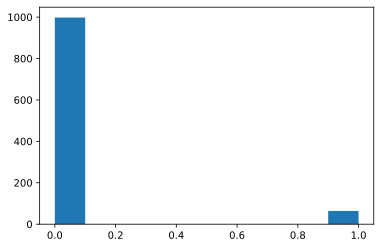

In [26]:
plt.hist(df_test['target'], bins=None)
plt.show()

**Выводы:**

Имеется несбалансированность, при моделировании необходимо это учесть

In [27]:
num_0 = int(round(len(df_test[df_test['target']==0])*0.6,0))

In [28]:
num_1 = len(df_test[df_test['target']==1])

df_test = pd.concat([df_test[df_test['target']==0] , df_test[df_test['target']==1].sample(num_0, replace=True) ])

(array([998.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 599.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

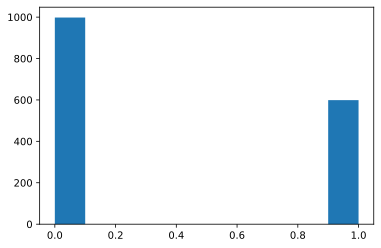

In [29]:
plt.hist(df_test['target'])

# 4. Признаки<a class='anchor' id='features'>

**рассмотрим подробнее признаки**

In [30]:
df_test.columns

Index(['class_rev_t-1', 'class_rev_t-2', 'class_rev_t-3', 'count5_pdz',
       'countall_pdz', 'dolg_zaem_t-1', 'dolg_zaem_t-2', 'dolg_zaem_t-3',
       'growth_dolg_zaem_t-1', 'growth_dolg_zaem_t-2', 'growth_kapital_t-1',
       'growth_kapital_t-2', 'growth_krat_liabil_t-1',
       'growth_krat_liabil_t-2', 'growth_oc_t-1', 'growth_oc_t-2',
       'growth_profit_t-1', 'growth_profit_t-2', 'growth_revenue_t-1',
       'growth_revenue_t-2', 'kapital_t-1', 'kapital_t-2', 'kapital_t-3',
       'krat_liabil_t-1', 'krat_liabil_t-2', 'krat_liabil_t-3',
       'krat_zaem_t-1', 'krat_zaem_t-2', 'krat_zaem_t-3', 'margin_profit_-1',
       'margin_profit_-2', 'margin_profit_-3', 'max_pdz', 'mean_pdz', 'name',
       'oborot_t-1', 'oborot_t-2', 'oborot_t-3', 'oc_t-1', 'oc_t-2', 'oc_t-3',
       'profit_t-1', 'profit_t-2', 'profit_t-3', 'reven_debt-1',
       'reven_debt-2', 'reven_debt-3', 'revenue_t-1', 'revenue_t-2',
       'revenue_t-3', 'sum5_pdz', 'target', 'class_dolg_zaem_t-1',
       'cl

In [31]:
df_test[df_test.columns[1:10]].describe()

,class_rev_t-2,class_rev_t-3,count5_pdz,countall_pdz,dolg_zaem_t-1,dolg_zaem_t-2,dolg_zaem_t-3,growth_dolg_zaem_t-1,growth_dolg_zaem_t-2
count,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00
mean,2.41,2.25,25.91,40.27,8417277614.88,7201916477.55,6649260767.60,-0.01,-0.02
std,1.46,1.54,63.14,80.97,50433445220.79,46316036274.79,40729734393.37,0.29,0.27
min,0.00,0.00,0.00,0.00,-21019.11,-21019.11,0.00,-0.60,-0.60
25%,2.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
50%,2.00,2.00,4.00,11.00,0.00,0.00,0.00,0.00,0.00
75%,4.00,4.00,22.00,41.00,88594904.46,86624203.82,51024840.76,0.00,0.00
max,4.00,4.00,445.00,478.00,1142726943312.10,1142726943312.10,1038017115286.62,0.60,0.60


In [32]:
df_test[df_test.columns[10:20]].describe()

,growth_kapital_t-1,growth_kapital_t-2,growth_krat_liabil_t-1,growth_krat_liabil_t-2,growth_oc_t-1,growth_oc_t-2,growth_profit_t-1,growth_profit_t-2,growth_revenue_t-1,growth_revenue_t-2
count,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00
mean,0.13,0.14,0.16,0.10,0.10,0.09,0.05,0.05,0.12,0.13
std,0.33,0.32,0.35,0.35,0.30,0.30,0.45,0.44,0.30,0.29
min,-0.60,-0.60,-0.60,-0.60,-0.60,-0.60,-0.60,-0.60,-0.60,-0.60
25%,0.00,0.00,-0.07,-0.09,-0.06,-0.06,-0.39,-0.34,-0.04,0.00
50%,0.09,0.08,0.12,0.06,0.00,0.00,0.00,0.00,0.07,0.08
75%,0.41,0.41,0.59,0.37,0.28,0.27,0.55,0.60,0.32,0.32
max,0.60,0.60,0.60,0.60,0.60,0.60,0.60,0.60,0.60,0.60


In [33]:
df_test[df_test.columns[20:30]].describe()

,kapital_t-1,kapital_t-2,kapital_t-3,krat_liabil_t-1,krat_liabil_t-2,krat_liabil_t-3,krat_zaem_t-1,krat_zaem_t-2,krat_zaem_t-3,margin_profit_-1
count,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00
mean,11121393492.97,9777478131.77,8756842446.23,6953091902.41,5598116504.67,5924257128.61,2302346823.06,1699580870.58,2134180207.71,0.05
std,50075485270.20,47465128071.57,44168846411.48,19282777768.04,16385036783.53,18024517505.48,9978013388.73,8025063049.84,9223727425.00,0.11
min,-169920523566.88,-169920523566.88,-59967979617.83,0.00,0.00,-334394.90,-401273.89,0.00,-591719.75,-0.30
25%,8514649.68,5899363.06,1475159.24,45986624.20,32061783.44,18728025.48,0.00,0.00,0.00,0.01
50%,75619745.22,60357324.84,43047770.70,195670700.64,167305095.54,134164331.21,7443949.04,3821656.05,1019108.28,0.03
75%,844466242.04,836486624.20,671885350.32,3436926751.59,1472168789.81,1253077707.01,177889808.92,141740764.33,86984713.38,0.09
max,1111498938216.56,1024324336305.73,960806615286.62,232557763057.32,181708303821.66,141510341401.27,138783612101.91,138783612101.91,94951369426.75,0.30


In [34]:
df_test[df_test.columns[30:40]].describe()

,margin_profit_-2,margin_profit_-3,max_pdz,mean_pdz,name,oborot_t-1,oborot_t-2,oborot_t-3,oc_t-1,oc_t-2
count,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00
mean,0.05,0.05,92.59,23.47,256.14,10503178501.09,9009703720.35,8902950551.79,11492270496.83,9398093451.50
std,0.10,0.09,184.05,47.39,157.73,30191420250.48,27289696364.07,29131213367.65,57862226199.00,53691747181.09
min,-0.30,-0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.01,0.00,1.00,1.00,114.00,70089171.97,49719745.22,26590445.86,7184713.38,2967515.92
50%,0.03,0.03,15.00,5.56,260.00,303854777.07,226256050.96,186939490.45,47682165.61,39729299.36
75%,0.07,0.07,61.00,20.61,398.00,4446515286.62,2671040127.39,1582012101.91,852494267.52,753043949.04
max,0.30,0.30,884.00,608.00,530.00,375316193630.57,297129728025.48,264286541401.27,1051440103821.66,1051440103821.66


In [35]:
df_test[df_test.columns[40:60]].describe()

,oc_t-3,profit_t-1,profit_t-2,profit_t-3,reven_debt-1,reven_debt-2,reven_debt-3,revenue_t-1,revenue_t-2,revenue_t-3,sum5_pdz,target,class_dolg_zaem_t-1,class_dolg_zaem_t-2,class_dolg_zaem_t-3,class_kapital_t-1,class_kapital_t-2,class_kapital_t-3,class_krat_liabil_t-1,class_krat_liabil_t-2
count,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00,1597.00
mean,8081013385.37,4439692069.53,3761188945.44,2782186532.47,0.16,0.16,0.14,17815757546.20,15495615543.48,12901230153.67,18483367.60,0.38,0.86,0.89,0.77,1.52,1.48,1.36,1.77,1.63
std,48114404657.42,20384850456.57,16127494281.96,12697486810.85,0.20,0.20,0.20,59659953022.88,52748125521.64,44395157008.89,41931453.24,0.48,1.41,1.44,1.37,1.66,1.67,1.64,1.57,1.54
min,0.00,-25208489171.97,-25208489171.97,-1126443312.10,0.00,0.00,0.00,0.00,0.00,0.00,-2978864.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,617197.45,1642675.16,647770.70,35031.85,0.00,0.00,0.00,215057324.84,157210828.03,95540127.39,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,29375159.24,17262420.38,13066242.04,11456687.90,0.07,0.06,0.03,673754777.07,579885350.32,445119745.22,1908878.28,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,1.00
75%,662700000.00,178568789.81,140567515.92,109364331.21,0.26,0.25,0.21,4619331210.19,3351922292.99,2522929936.31,14272077.84,1.00,1.00,1.00,1.00,3.00,3.00,3.00,4.00,3.00
max,937907628025.48,342085019108.28,209145149044.59,148351361783.44,0.60,0.60,0.60,559327575159.24,387937496178.34,290395666878.98,271633129.99,1.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00


<function matplotlib.pyplot.show(close=None, block=None)>

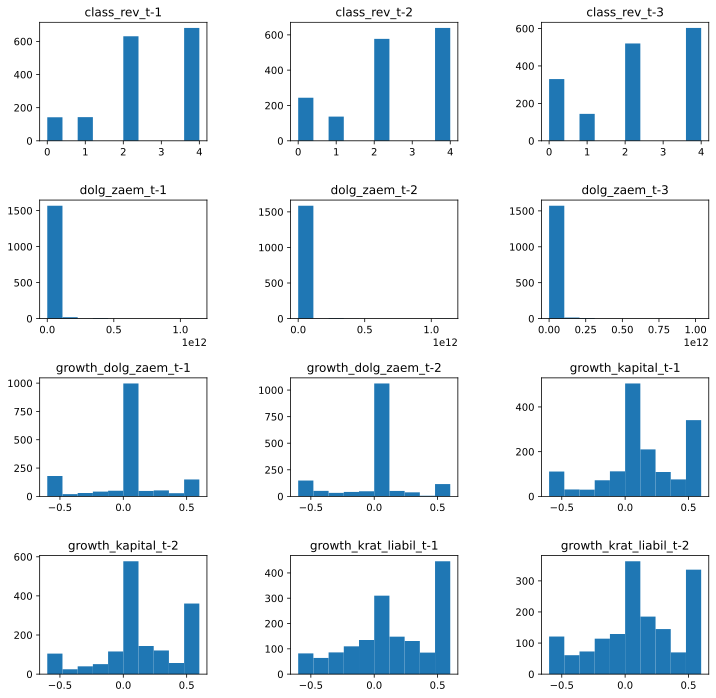

In [36]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.subplot(4, 3, 1)
plt.title('class_rev_t-1')
plt.hist(df_test['class_rev_t-1'])
plt.subplot(4, 3, 2)
plt.title('class_rev_t-2')
plt.hist(df_test['class_rev_t-2'])
plt.subplot(4, 3, 3)
plt.title('class_rev_t-3')
plt.hist(df_test['class_rev_t-3'])
plt.subplot(4, 3, 4)
plt.title('dolg_zaem_t-1')
plt.hist(df_test['dolg_zaem_t-1'])
plt.subplot(4, 3, 5)
plt.title('dolg_zaem_t-2')
plt.hist(df_test['dolg_zaem_t-2'])
plt.subplot(4, 3, 6)
plt.title('dolg_zaem_t-3')
plt.hist(df_test['dolg_zaem_t-3'])
plt.subplot(4, 3, 7)
plt.title('growth_dolg_zaem_t-1')
plt.hist(df_test['growth_dolg_zaem_t-1'])
plt.subplot(4, 3, 8)
plt.title('growth_dolg_zaem_t-2')
plt.hist(df_test['growth_dolg_zaem_t-2'])
plt.subplot(4, 3, 9)
plt.title('growth_kapital_t-1')
plt.hist(df_test['growth_kapital_t-1'])
plt.subplot(4, 3, 10)
plt.title('growth_kapital_t-2')
plt.hist(df_test['growth_kapital_t-2'])
plt.subplot(4, 3, 11)
plt.title('growth_krat_liabil_t-1')
plt.hist(df_test['growth_krat_liabil_t-1'])
plt.subplot(4, 3, 12)
plt.title('growth_krat_liabil_t-2')
plt.hist(df_test['growth_krat_liabil_t-2'])

plt.show

Классы по выручке сбалансированы, показатели по росту значительно разнятся, необходима корректировка, например, с ограничением максимин значениий для балансироваки

<function matplotlib.pyplot.show(close=None, block=None)>

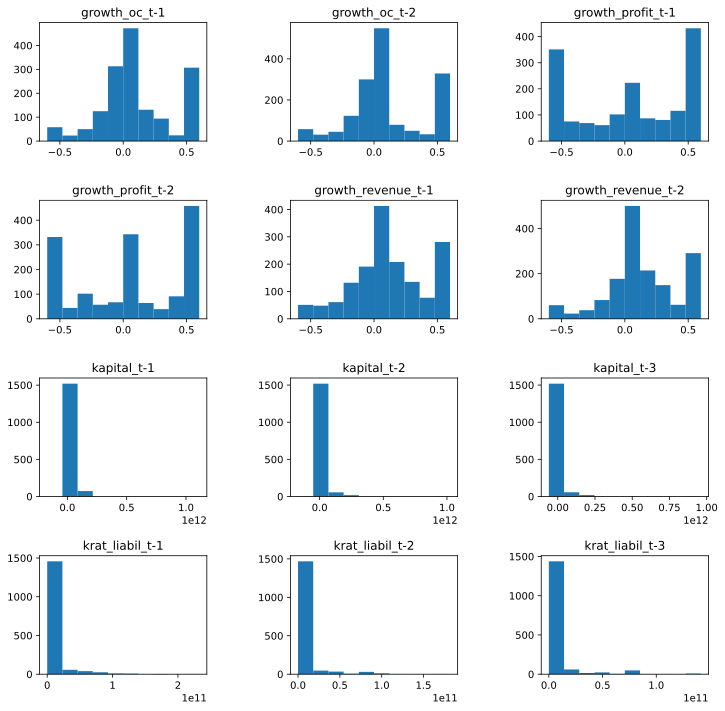

In [37]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.subplot(4, 3, 1)
plt.title('growth_oc_t-1')
plt.hist(df_test['growth_oc_t-1'])
plt.subplot(4, 3, 2)
plt.title('growth_oc_t-2')
plt.hist(df_test['growth_oc_t-2'])
plt.subplot(4, 3, 3)
plt.title('growth_profit_t-1')
plt.hist(df_test['growth_profit_t-1'])
plt.subplot(4, 3, 4)
plt.title('growth_profit_t-2')
plt.hist(df_test['growth_profit_t-2'])
plt.subplot(4, 3, 5)
plt.title('growth_revenue_t-1')
plt.hist(df_test['growth_revenue_t-1'])
plt.subplot(4, 3, 6)
plt.title('growth_revenue_t-2')
plt.hist(df_test['growth_revenue_t-2'])
plt.subplot(4, 3, 7)
plt.title('kapital_t-1')
plt.hist(df_test['kapital_t-1'])
plt.subplot(4, 3, 8)
plt.title('kapital_t-2')
plt.hist(df_test['kapital_t-2'])
plt.subplot(4, 3, 9)
plt.title('kapital_t-3')
plt.hist(df_test['kapital_t-3'])
plt.subplot(4, 3, 10)
plt.title('krat_liabil_t-1')
plt.hist(df_test['krat_liabil_t-1'])
plt.subplot(4, 3, 11)
plt.title('krat_liabil_t-2')
plt.hist(df_test['krat_liabil_t-2'])
plt.subplot(4, 3, 12)
plt.title('krat_liabil_t-3')
plt.hist(df_test['krat_liabil_t-3'])

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

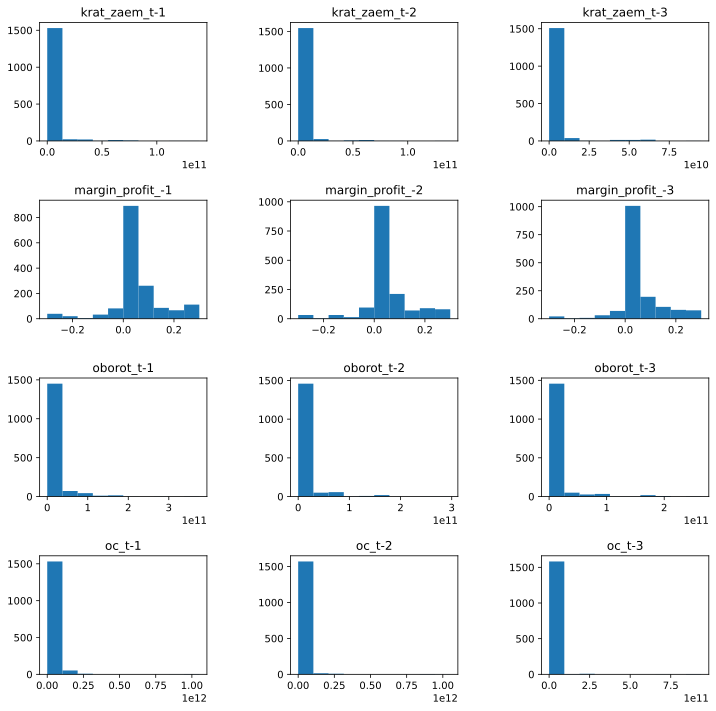

In [38]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.subplot(4, 3, 1)
plt.title('krat_zaem_t-1')
plt.hist(df_test['krat_zaem_t-1'])
plt.subplot(4, 3, 2)
plt.title('krat_zaem_t-2')
plt.hist(df_test['krat_zaem_t-2'])
plt.subplot(4, 3, 3)
plt.title('krat_zaem_t-3')
plt.hist(df_test['krat_zaem_t-3'])
plt.subplot(4, 3, 4)
plt.title('margin_profit_-1')
plt.hist(df_test['margin_profit_-1'])
plt.subplot(4, 3, 5)
plt.title('margin_profit_-2')
plt.hist(df_test['margin_profit_-2'])
plt.subplot(4, 3, 6)
plt.title('margin_profit_-3')
plt.hist(df_test['margin_profit_-3'])
plt.subplot(4, 3, 7)
plt.title('oborot_t-1')
plt.hist(df_test['oborot_t-1'])
plt.subplot(4, 3, 8)
plt.title('oborot_t-2')
plt.hist(df_test['oborot_t-2'])
plt.subplot(4, 3, 9)
plt.title('oborot_t-3')
plt.hist(df_test['oborot_t-3'])
plt.subplot(4, 3, 10)
plt.title('oc_t-1')
plt.hist(df_test['oc_t-1'])
plt.subplot(4, 3, 11)
plt.title('oc_t-2')
plt.hist(df_test['oc_t-2'])
plt.subplot(4, 3, 12)
plt.title('oc_t-3')
plt.hist(df_test['oc_t-3'])

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

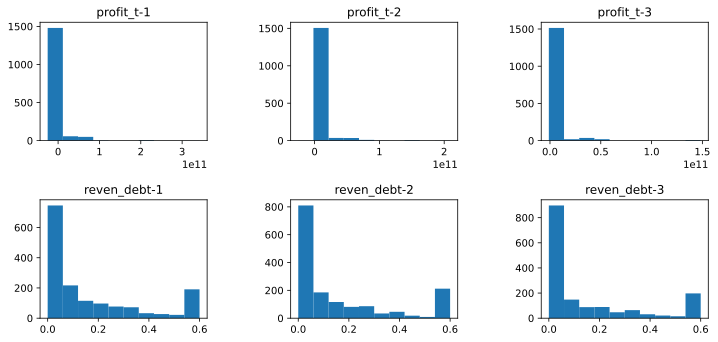

In [39]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.subplot(4, 3, 1)
plt.title('profit_t-1')
plt.hist(df_test['profit_t-1'])
plt.subplot(4, 3, 2)
plt.title('profit_t-2')
plt.hist(df_test['profit_t-2'])
plt.subplot(4, 3, 3)
plt.title('profit_t-3')
plt.hist(df_test['profit_t-3'])
plt.subplot(4, 3, 4)
plt.title('reven_debt-1')
plt.hist(df_test['reven_debt-1'])
plt.subplot(4, 3, 5)
plt.title('reven_debt-2')
plt.hist(df_test['reven_debt-2'])
plt.subplot(4, 3, 6)
plt.title('reven_debt-3')
plt.hist(df_test['reven_debt-3'])

plt.show

**Выводы**

Использовать абсолютныепоказатели не надо, только классифицированные. 

Относительные расчетные показатели и показатели роста с учетом введенных ограничений в целом пропорциональны. 

Использовать все признаки не имеет смысла ввиду высокой автокорреляции, показатели-классификаторы оптимальнее всего взять текущего года, поскольку показатели роста будут учитывать предыдущие периоды, также можно ограничить балансовые показатели и не рассматривать связанные. 

In [40]:
#itog_columns = ['target', 'class_rev_t-1', 'class_rev_t-2', 'class_rev_t-3',
#       'growth_dolg_zaem_t-1', 'growth_dolg_zaem_t-2', 'growth_kapital_t-1',
#       'growth_kapital_t-2', 'growth_krat_liabil_t-1',
#       'growth_krat_liabil_t-2', 'growth_oc_t-1', 'growth_oc_t-2',
#       'growth_profit_t-1', 'growth_profit_t-2', 'growth_revenue_t-1',
#       'growth_revenue_t-2', 'margin_profit_-1', 'margin_profit_-2', 'margin_profit_-3', 'reven_debt-1',
#       'reven_debt-2', 'reven_debt-3', 'class_dolg_zaem_t-1',
#       'class_dolg_zaem_t-2', 'class_dolg_zaem_t-3', 'class_kapital_t-1',
#       'class_kapital_t-2', 'class_kapital_t-3', 'class_krat_liabil_t-1',
#       'class_krat_liabil_t-2', 'class_krat_liabil_t-3', 'class_krat_zaem_t-1',
#       'class_krat_zaem_t-2', 'class_krat_zaem_t-3', 'class_oborot_t-1',
#       'class_oborot_t-2', 'class_oborot_t-3', 'class_oc_t-1', 'class_oc_t-2',
#       'class_oc_t-3', 'class_profit_t-1', 'class_profit_t-2',
#       'class_profit_t-3']

In [41]:
itog_columns = ['target', 'class_rev_t-1', 'class_kapital_t-1', 'class_oborot_t-1', 'class_oc_t-1', 'class_profit_t-1',
                'growth_kapital_t-1', 'growth_krat_liabil_t-1', 'growth_oc_t-1', 'growth_profit_t-1', 'growth_revenue_t-1', 
                'margin_profit_-1', 'reven_debt-1', 'margin_profit_-2', 'reven_debt-2',
               'class_rev_t-2', 'class_oborot_t-2', 'class_oc_t-2', 'class_profit_t-2', 'class_rev_t-2']

<function matplotlib.pyplot.show(close=None, block=None)>

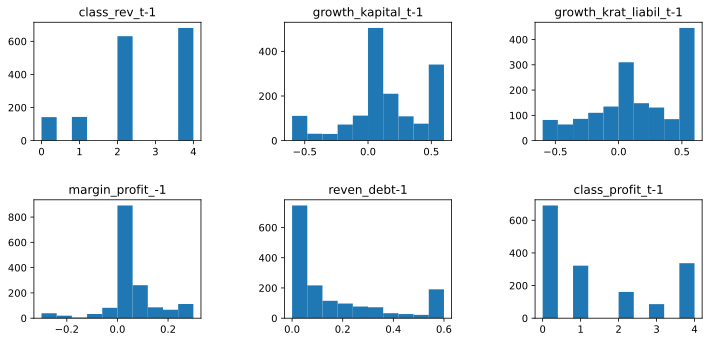

In [42]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.subplot(4, 3, 1)
plt.title('class_rev_t-1')
plt.hist(df_test['class_rev_t-1'])
plt.subplot(4, 3, 2)
plt.title('growth_kapital_t-1')
plt.hist(df_test['growth_kapital_t-1'])
plt.subplot(4, 3, 3)
plt.title('growth_krat_liabil_t-1')
plt.hist(df_test['growth_krat_liabil_t-1'])
plt.subplot(4, 3, 4)
plt.title('margin_profit_-1')
plt.hist(df_test['margin_profit_-1'])
plt.subplot(4, 3, 5)
plt.title('reven_debt-1')
plt.hist(df_test['reven_debt-1'])
plt.subplot(4, 3, 6)
plt.title('class_profit_t-1')
plt.hist(df_test['class_profit_t-1'])

plt.show

In [43]:
#datadata = df_test[['target', 'class_rev_t-1']]
#datadata.to_csv('datadata.csv', sep='\t', index=None)

**Анализируем итоговую базу данных для тестов**

In [44]:
df_itog = df_test[itog_columns]

In [45]:
df_itog

,target,class_rev_t-1,class_kapital_t-1,class_oborot_t-1,class_oc_t-1,class_profit_t-1,growth_kapital_t-1,growth_krat_liabil_t-1,growth_oc_t-1,growth_profit_t-1,growth_revenue_t-1,margin_profit_-1,reven_debt-1,margin_profit_-2,reven_debt-2,class_rev_t-2,class_oborot_t-2,class_oc_t-2,class_profit_t-2,class_rev_t-2
0,0,4,4,4,4,4,-0.23,0.31,0.19,-0.60,-0.11,0.02,0.01,0.15,0.00,4,4,4,4,4
1,0,2,2,1,2,2,0.12,0.60,0.03,0.60,0.60,0.10,0.12,0.04,0.18,2,1,2,1,2
2,0,4,4,3,3,0,0.02,0.30,-0.02,-0.60,-0.04,-0.04,0.00,0.06,0.00,4,3,3,3,4
3,0,4,4,4,4,4,0.43,0.01,0.34,0.52,0.22,0.30,0.32,0.29,0.24,4,4,4,4,4
4,0,4,4,4,4,4,0.60,0.60,0.02,0.42,0.29,0.30,0.60,0.30,0.60,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,1,2,0,1,0,0,0.01,0.60,0.00,-0.47,-0.37,0.01,0.00,0.01,0.00,2,1,0,0,2
118,1,2,0,1,0,0,0.12,-0.16,-0.09,0.15,0.60,-0.02,0.49,-0.03,0.60,1,1,0,0,1
311,1,2,0,1,1,1,0.60,0.15,0.56,0.27,-0.11,0.06,0.35,0.04,0.25,2,1,1,1,2
260,1,4,3,4,3,4,0.16,0.60,0.60,0.60,0.60,0.03,0.00,0.04,0.00,4,4,2,3,4


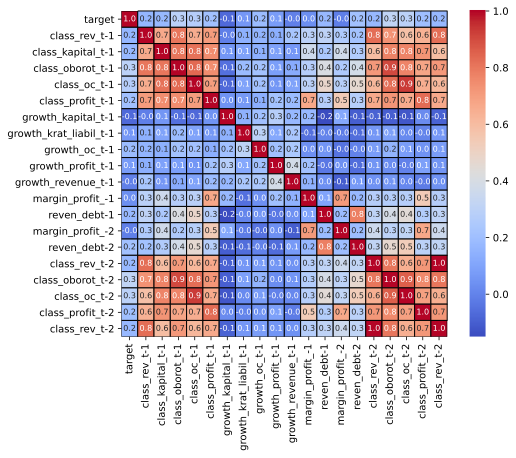

In [46]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_itog.corr(), cmap= 'coolwarm', linewidths=1, fmt='.1f', annot=True, linecolor='black', square=True, annot_kws={'size':8})
plt.show()

Низкое значение корреляции связано с тем, что много компаний даже с высокой выручкой допускали просрочки оплаты дебиторской задолженности на значимый период (около месяца), однако нелинейные модели анализа смогут выявить более тонкие закономерности и связи. 

Приведение данных к сбалансированному виду сделает модель более точной. 

# 5. Моделирование<a class='anchor' id='models'>

In [47]:
results_all = {}

In [48]:
feat = itog_columns[1:50]
target = itog_columns[0]

In [49]:
X = df_test[feat]
y = df_test[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle=True, random_state=42)

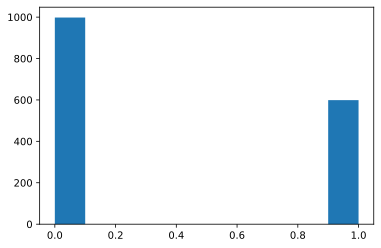

In [50]:
plt.hist(y, bins=None)
plt.show()

In [51]:
adaboost = AdaBoostClassifier(n_estimators=50)
gboost = GradientBoostingClassifier(n_estimators=50)
rand_forrest = RandomForestClassifier(n_estimators=10)
d_tree = DecisionTreeClassifier(max_depth=30)
mlp_class = MLPClassifier(solver='sgd', alpha=100, hidden_layer_sizes=(2, 2), random_state=1)

In [52]:
mlp_class.fit(X_train, y_train)
preds_mlp_class = mlp_class.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_mlp_class)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

results_all['mlp_class'] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                           roc_auc_score(y_test, preds_mlp_class), r2(y_test, preds_mlp_class)]

In [53]:
adaboost.fit(X_train, y_train)

preds_adaboost = adaboost.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds_adaboost)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

results_all['adaboost'] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                           roc_auc_score(y_test, preds_adaboost), r2(y_test, preds_adaboost)]

In [54]:
#preds_adaboost = (preds_adaboost < 0.6).astype(int)
#preds_adaboost

In [55]:
# preds_gboost1 = (preds_gboost < 0.5).astype(int)

# preds_gboost1

In [56]:
gboost.fit(X_train, y_train)

preds_gboost = gboost.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_gboost)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

results_all['gboost'] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                         roc_auc_score(y_test, preds_gboost), r2(y_test, preds_gboost)]

In [57]:
rand_forrest.fit(X_train, y_train)

preds_rand_forrest = rand_forrest.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_rand_forrest)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

results_all['rand_forrest'] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                               roc_auc_score(y_test, preds_rand_forrest), r2(y_test, preds_rand_forrest)]

In [58]:
d_tree.fit(X_train, y_train)

preds_d_tree = rand_forrest.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_d_tree)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

results_all['d_tree'] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                         roc_auc_score(y_test, preds_d_tree), r2(y_test, preds_d_tree)]

In [59]:
def results(data_res):
    df = pd.DataFrame(data_res).T
    df.columns=['Best Threshold', 'F-Score', 'Precision', 'Recall', 'roc_auc_score', 'R_2']
    return df

In [60]:
results(results_all)

,Best Threshold,F-Score,Precision,Recall,roc_auc_score,R_2
mlp_class,0.37,0.54,0.37,1.00,0.50,-0.00
adaboost,0.49,0.75,0.61,0.96,0.86,-0.04
gboost,0.32,0.84,0.72,1.00,0.95,0.55
rand_forrest,0.80,0.98,1.00,0.96,1.00,0.86
d_tree,0.80,0.98,1.00,0.96,1.00,0.86


**Анализ значимости признаков**

In [61]:
feature_importances = pd.DataFrame(zip(X_train, gboost.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,class_oborot_t-1,0.21
7,growth_oc_t-1,0.15
9,growth_revenue_t-1,0.12
10,margin_profit_-1,0.10
11,reven_debt-1,0.07
12,margin_profit_-2,0.06
6,growth_krat_liabil_t-1,0.05
5,growth_kapital_t-1,0.05
13,reven_debt-2,0.04
1,class_kapital_t-1,0.03


В целом модели показали приемлемый результат, с учетом крайне плохих вводных данных и необходимости корректировки для построения сбалансированной выборки.

Наиболее адекватной представляется модель градиентного бустинга, поскольку остальные, скорее всего, были переобучены (из-за необходимости балансировки данных) и на валидационной выборке дадут плохой результат.

Существенно улучшить модели (изменяя их параметры или изменяя параметры таргета и переменных) не получилось на более, чем сотне различных комбинаций.

В метриках мы смотрим на (в основном) в данном случае на Precision (сколько компаний модель подсчитала "плохими", в то время как они действительно были "плохими"). 
Также мы можем посмотреть на показатель того, сколько компаний модель отметила как "плохие" (допускали значимые просрочки), в то время как на самом деле они "хорошие" (не допускали значимых просрочек). Чем меньше этот показатель (т.е. модель должна отсеить компании, которым мы не будем давать отсрочки, в то время как они нормальные и с ними можно больше работать).

Остальные включенные метрики использовались просто как вспомогательные.

# 6. Проверка на валидационном сете<a class='anchor' id='valid'>

In [62]:
# применяем предобработку для валидационного сета
df21 = make_df(data_2021, year_3 = [-3, -2, -1], year_2 = [-2, -1], features = features, data_year=2021, f_all = f_all)


In [63]:
additional_transform(df21)

,kapital_t-3,name,oborot_t-1,oborot_t-3,profit_t-1,PDZ90,countall_pdz_19,oc_t-3,mean_pdz_20,mean_pdz_19,...,class_krat_zaem_t-3,class_oborot_t-1,class_oborot_t-2,class_oborot_t-3,class_oc_t-1,class_oc_t-2,class_oc_t-3,class_profit_t-1,class_profit_t-2,class_profit_t-3
0,2289273885.35,0,6170107006.37,6077447770.70,5971943312.10,0,0,2145239490.45,6.40,0.00,...,2,4,4,4,4,4,4,4,4,4
1,2378698089.17,2,753777707.01,1590216560.51,-355471974.52,0,2,928738853.50,5.33,5.50,...,0,2,2,3,4,4,3,0,0,0
2,10544059872.61,4,24052113375.80,20771890445.86,57368819108.28,0,2,30089698726.11,1.00,2.00,...,4,4,4,4,4,4,4,4,4,4
3,63850556050.96,5,25423777070.06,44115340127.39,42814828662.42,0,0,35873358598.73,17.67,0.00,...,4,4,4,4,4,4,4,4,4,4
4,1500636942.68,6,32360966242.04,26334457324.84,8212564331.21,0,0,11142412738.85,0.00,0.00,...,2,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,0.00,522,131066878.98,0.00,6487898.09,0,0,0.00,1.75,0.00,...,0,1,1,0,0,0,0,0,0,0
321,0.00,523,0.00,0.00,0.00,0,0,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
322,0.00,525,42541401.27,0.00,8932484.08,0,0,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
323,366526114.65,527,368010191.08,379885987.26,26442038.22,0,0,131241401.27,0.00,0.00,...,0,2,2,2,1,2,2,1,2,2


In [64]:
df21[feat]

,class_rev_t-1,class_kapital_t-1,class_oborot_t-1,class_oc_t-1,class_profit_t-1,growth_kapital_t-1,growth_krat_liabil_t-1,growth_oc_t-1,growth_profit_t-1,growth_revenue_t-1,margin_profit_-1,reven_debt-1,margin_profit_-2,reven_debt-2,class_rev_t-2,class_oborot_t-2,class_oc_t-2,class_profit_t-2,class_rev_t-2
0,4,4,4,4,4,0.41,-0.04,0.19,0.60,-0.14,0.21,0.00,0.11,0.00,4,4,4,4,4
1,4,4,2,4,0,-0.05,0.31,0.04,0.60,-0.06,-0.14,0.00,-0.04,0.00,4,2,4,0,4
2,4,4,4,4,4,0.60,-0.33,0.08,0.02,0.02,0.30,0.60,0.30,0.60,4,4,4,4,4
3,4,4,4,4,4,0.17,-0.57,0.07,0.23,0.19,0.30,0.05,0.30,0.07,4,4,4,4,4
4,4,4,4,4,4,0.60,0.08,-0.02,0.51,0.01,0.12,0.52,0.08,0.60,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,2,0,1,0,0,0.37,0.60,0.48,0.55,0.60,0.02,0.00,0.03,0.00,2,1,0,0,2
321,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0
322,0,0,0,0,0,0.60,0.36,0.60,0.60,-0.17,0.26,0.03,0.01,0.02,0,0,0,0,0
323,2,2,2,1,1,-0.06,-0.42,-0.25,-0.60,-0.10,0.03,0.00,0.07,0.00,4,2,2,2,4


**Расчетный target валидационного сета по выбранном модели**

In [76]:
df21['target'] = gboost.predict(df21[feat])

**Фактический таргет валдиационного сета**

In [109]:
df21['target_real'] = 0

df21.loc[(df21['PDZ30']==1) & (df21['PDZ90']==1) & ((df21['PDZ365']==1) | (df21['PDZ700']==1)), 'target_real'] = 1


Данные для построения целевого показателя в 2021 году отличаются от данные 2019 и 2020 годов. Здесь представлены просто факт просрочки в определенный период без указания суммы, количества раз просрочек и других параметров.

Считаем, целевой показатель как факт наличия просрочки в 30 дней И до 90 дней И (ИЛИ просрочки до 365 дне ИЛИ 365+ дней)

**Анализ результатов**

In [110]:
sum(df21['target_real']), sum(df21['target'])

(13, 37)

Confusion matrix, without normalization
[[284  28]
 [  4   9]]


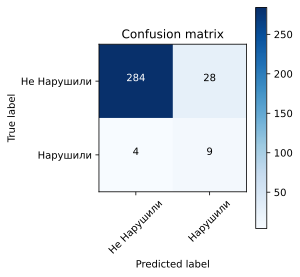

In [111]:
font = {'size' : 10}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(df21['target_real'], df21['target'])
plt.figure(figsize=(4,4))
plot_confusion_matrix(cnf_matrix, classes=['Не Нарушили', 'Нарушили'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [112]:
precision, recall, thresholds = precision_recall_curve(df21['target'], df21['target_real'])
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

results_all['target_valid'] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                         roc_auc_score(df21['target'], df21['target_real']), r2(df21['target'], df21['target_real'])]

In [113]:
results(results_all)

,Best Threshold,F-Score,Precision,Recall,roc_auc_score,R_2
mlp_class,0.37,0.54,0.37,1.00,0.50,-0.00
adaboost,0.49,0.75,0.61,0.96,0.86,-0.04
gboost,0.32,0.84,0.72,1.00,0.95,0.55
rand_forrest,0.80,0.98,1.00,0.96,1.00,0.86
d_tree,0.80,0.98,1.00,0.96,1.00,0.86
target_valid,1.00,0.36,0.69,0.24,0.61,0.02


В целом валидационный сет также не очень хорошего качества, кроме того, данные для построения целевой переменной отличаются от данных 2019-2020 годов (здесь просто факт наличия просрочки, без указания суммы, количества раз просрочки и других деталей).

Несмотря на это, при целевых 13 компаний, которые допустили значимую просрочку исходя из указанного расчетного показателя, модель правильно определила 9 компаний (70% precision) и лишь 4 отнесла в те, с которыми можно работать в отсрочку, но они на самом деле ее допустили.

Компании, которые НЕ нарушают обязательств по уплате дебиторской задолженности модель выявляет очень хорошо: из 312 компаний только 28 (8.9%) были отнесены к ненадежным, хотя с ними и можно было работать в отсрочку. 

По указанным метрикам модель на валидационном сете показала хорошие результаты.

# 7. API / Pipeline<a class='anchor' id='pipeline'>

In [71]:
#обработка признаков в пайплайне 

class DFProcessing(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        feat = ['target', 'class_rev_t-1', 'class_kapital_t-1', 'class_oborot_t-1', 'class_oc_t-1', 'class_profit_t-1',
                'growth_kapital_t-1', 'growth_krat_liabil_t-1', 'growth_oc_t-1', 'growth_profit_t-1', 'growth_revenue_t-1', 
                'margin_profit_-1', 'reven_debt-1', 'margin_profit_-2', 'reven_debt-2',
               'class_rev_t-2', 'class_oborot_t-2', 'class_oc_t-2', 'class_profit_t-2', 'class_rev_t-2']
        X_df = make_df(X, year_3 = [-3, -2, -1], year_2 = [-2, -1], features = features, data_year=2021, f_all = f_all)
        X_data = additional_transform(X_df)
        X_data = X_data[feat]
        return X_data


In [63]:
steps = [('transformfeatures', DFProcessing()), ('gboost', gboost)]
pipeline = Pipeline(steps)

In [65]:
predictions = pipeline.predict_proba(data_2021)

In [66]:
pd.DataFrame({'preds': predictions[:, 1]}).to_csv("test_predictions.csv", index=None)

In [68]:
#проверка трансормации пайплайна
data_check = pipeline[0].transform(data_2021)

In [72]:
data_check.head()

,class_rev_t-1,growth_kapital_t-1,growth_krat_liabil_t-1,growth_oc_t-1,growth_profit_t-1,growth_revenue_t-1,growth_revenue_t-2,margin_profit_-2,margin_profit_-1,reven_debt-1,class_kapital_t-1,class_oborot_t-1,class_oc_t-1,class_profit_t-1
0,4,0.41,-0.04,0.19,0.60,-0.14,-0.13,0.11,0.21,0.00,4,4,4,4
1,3,-0.05,0.31,0.04,0.60,-0.06,0.06,-0.04,-0.14,0.00,4,3,4,0
2,4,0.60,-0.33,0.08,0.02,0.02,0.09,0.30,0.30,0.60,4,4,4,4
3,4,0.17,-0.57,0.07,0.23,0.19,0.13,0.30,0.30,0.05,4,4,4,4
4,4,0.60,0.08,-0.02,0.51,0.01,-0.12,0.08,0.12,0.52,4,4,4,4


In [ ]:
import dill
with open("gboost_pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)

# 8. DFD модель (Flask / Spark / Stream)<a class='anchor' id='flask'>

In [4]:
#Функция для online обработки через flask 

In [3]:
import urllib.request
import json      

def get_prediction(class_rev_t_1, growth_kapital_t_1, growth_krat_liabil_t_1, growth_oc_t_1, growth_profit_t_1, 
                   growth_revenue_t_1, growth_revenue_t_2, margin_profit_2, margin_profit_1, reven_debt_1, class_kapital_t_1, 
                   class_oborot_t_1, class_oc_t_1, class_profit_t_1):
    body = {'class_rev_t-1': class_rev_t_1, 'growth_kapital_t-1': growth_kapital_t_1, 'growth_krat_liabil_t-1': growth_krat_liabil_t_1, 
            'growth_oc_t-1': growth_oc_t_1, 'growth_profit_t-1': growth_profit_t_1, 'growth_revenue_t-1': growth_revenue_t_1, 
            'growth_revenue_t-2': growth_revenue_t_2, 'margin_profit_-2': margin_profit_2, 'margin_profit_-1': margin_profit_1, 
            'reven_debt-1': reven_debt_1, 'class_kapital_t-1': class_kapital_t_1, 'class_oborot_t-1': class_oborot_t_1, 
            'class_oc_t-1': class_oc_t_1, 'class_profit_t-1': class_profit_t_1} 

    myurl = "http://localhost:8080/predict"
    req = urllib.request.Request(myurl)
    req.add_header('Content-Type', 'application/json; charset=utf-8')
    jsondata = json.dumps(body)
    jsondataasbytes = jsondata.encode('utf-8')   # needs to be bytes
    req.add_header('Content-Length', len(jsondataasbytes))
    #print (jsondataasbytes)
    response = urllib.request.urlopen(req, jsondataasbytes)
    return json.loads(response.read())['predictions']

In [7]:
#ОБЩАЯ DFD МОДЕЛЬ РАБОТЫ

В нашем случае ограниченных по количеству данных оптимальная схема работы видится через докер и rest API
Клиент отправляет данные по указанным параметрам в указанном порядке
{class_rev_t_1, growth_kapital_t_1, growth_krat_liabil_t_1, growth_oc_t_1, growth_profit_t_1, 
                   growth_revenue_t_1, growth_revenue_t_2, margin_profit_2, margin_profit_1, reven_debt_1, class_kapital_t_1, 
                   class_oborot_t_1, class_oc_t_1, class_profit_t_1}

через свой клиент (возможно либо online кабинет, либо отправляет csv файл) на сервер и получает готовый ответ (стоит сотрудничать с компанией в отсрочку платежа или она рискованная):

**Client <--> Web Server Container <--> HTTP Server  <--> HTTP REST API (Flask) <--> Model Prediction**


В указанных в задаче условиях модель обновляется не часто, либо раз в год либо по мере накопления существенного количества новых данных (контрагентов)

**В случае, если данных очень много и по контрагентам поступают запросы на обработку в режиме реального времени, необходимо подключать инфраструктуру spark**

<img src="przimg.jpg">

# 9. Выводы и заключение<a class='anchor' id='rezult'>

**1. Предоставленные данные были крайне некачественными. Многие показатели невозможно было использовать, общий объем ограничен.**

Данные для построения целевой переменной в 2021 году существенно отличаются от данных для целевой переменной в 2019 и 2020 годах (там данные и показатели сопоставимы).
В результате анализа выяснилось, что выборка помимо того, что не большая, но и не достаточно структурирована, т.е. целевые компании могут быть совершенно разными: и с огромной выручкой и прибылью и совсем не большие. 
Уточнение целевого показателя вело к существенному ограничению целевой выборки и разбалансировки данных. 

Сами данные были записаны в неудобном для обработке формате. Для приведения к единой форме необходимы было разработать расширенный функционал для обработки по каждому году.

В результате получилось сформировать единую таблицу за 2019 и 2020 годы из 1062 компаний на которой обучались модели.

Данные 2021 года (325 компаний) использовались как валидационный сет для проверки итоговой модели.


**2. В целом модели показали приемлемый результат, с учетом крайне плохих вводных данных и необходимости корректировки для построения сбалансированной выборки.**

Наиболее адекватной представляется модель градиентного бустинга, поскольку остальные, скорее всего, были переобучены (из-за необходимости балансировки данных) и на валидационной выборке дадут плохой результат.

Существенно улучшить модели (изменяя их параметры или изменяя параметры таргета и переменных) не получилось на более, чем сотне различных комбинаций.


**3. В целом валидационный сет также не очень хорошего качества, кроме того, данные для построения целевой переменной отличаются от данных 2019-2020 годов (здесь просто факт наличия просрочки, без указания суммы, количества раз просрочки и других деталей).**

Несмотря на это, при целевых 13 компаний, которые допустили значимую просрочку исходя из указанного расчетного показателя, модель правильно определила 9 компаний и лишь 4 отнесла в те, с которыми можно работать в отсрочку, но они на самом деле ее допустили.

Компании, которые НЕ нарушают обязательств по уплате дебиторской задолженности модель выявляет очень хорошо: из 312 компаний только 28 (8.9%) были отнесены к ненадежным, хотя с ними и можно было работать в отсрочку.


**4. Дополнительно был построен pipeline, который можно использовать как API для доступа к модели**

На тестировании pipeline отработал полностью корректно.

